# Training a Dense Neural Network

The handwritten digit recognition is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). We use `pytorchcv` helper to load all data we have talked about in the previous unit.

In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

## Fully-Connected Dense Neural Network

A simplest **neural network** in PyTorch consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Linear** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class).

![](/images/dense_onelayer.png)

As we discussed above, the dimension of our digit images is $1\times28\times28$. Because the input dimension of fully-connected layer is 784, we need to insert another layer into the network, called **Flatten**, to change tensor shape from $1\times28\times28$ to $784$.

We want $n$-th output of the network to return the probability of the input digit being equal to $n$. Because output of fully-connected layer is not normalized in any way, it cannot be regarded as probablility. To turn it into a probability, we apply another layer, called **Softmax**.

> In PyTorch, it is more convenient to use **LogSoftmax** function, which will additionally compute logarithms of output probabilities. To turn the output vector into the actual probablities, we need to take **torch.exp** of the ouput. 

Thus, the architecture of our network can be represented by the following sequence of layers:

![](images/onelayer_layers.png)

It can be defined in PyTorch in the following way, using `Sequential` syntax:

In [3]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

## Training the Network

A network defined in this manner can take any digit as input, and produce a vector of probabilities as an output. Let's see how this network performs, but giving it a digit from our dataset:

In [4]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0]))

Digit to be predicted:  5


tensor([[0.0745, 0.0873, 0.1155, 0.1382, 0.0987, 0.0864, 0.1008, 0.0953, 0.0804,
         0.1229]], grad_fn=<ExpBackward>)

As you can see, the network predicts almost equal probablilites for each digit, because it is not trained. To train the network, we need to present it with our training data.

To do so, we will need to chunk original dataset into **batches** of a certain size, let's say 64. An object called **DataLoader** can do it for us automatically:

In [5]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64) # we can use larger batch size for testing

The process of training looks like this:

1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2. We calculate the result that network predicts on this minibatch. 
3. The difference between this result and expected result is calculated using a special function called **loss function**
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the preformance of the network. The amount of adjustment is controlled by a parameter called **learning rate**, and the details of optimization alogrithm are defined in the **optimizer** object.
5. We repeat those steps until the whole dataset is used.

Complete pass through the dataset is called **an epoch**. Here is a function that performs one epoch training: 

In [6]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.00593387451171875, 0.89305)

This function is pretty generic, which will allow us to use it later in all our examples. It takes the following parameters:
* **Neural network** itself
* **DataLoader**, which defines the data to train on
* **Loss Function**, which is a function that measures the difference between expected result and the one produced by the network. In most of the classification tasks `NLLLoss` is used, so we will make it a default.
* **Optimizer**, which defined an *optimization algorithm*. The most traditional algorithm is *stochastic gradient descent*, but we will use more advanced version called **Adam** by default.
* **Learning rate** defines the speed at which network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would behave badly. Too small learning rate results in very slow learning. 

Here is what we do when training:
* Switch the network to training mode (`net.train()`)
* Go over all batches in the dataset, and for each batch do the following:
   - compute predictions made by the network on this batch (`out`)
   - compute `loss`, which is the discrepancy between predicted and expected values
   - try to minimize the loss by adjusting weights of the network (`optimizer.step()`)
   - compute the number of correctly predicted cases (**accuracy**)

The function calculates and returns the average loss per one data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether network actually learns something.

It is also important to control the accuracy on the test dataset (also called **validation accuracy**). A rich neural network with a lot of parameters can approximate any training dataset very well, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:


In [7]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005862992477416992, 0.8932)

In most of the cases, we train the model for several epochs, observing training and validation accuracy. Normally, training accuracy will tend to increase, while validation accuracy may start to decrease at some point. That would be an indication of **overfitting**, and we probably need to stop training.

Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.

In [8]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.898, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


This function prints diagnostic messages with accuracy on training and valiadation data obtained on each epoch, and also returns this data as a dictionary (so-called **history**). We can then visualize this data to make sense of what goes on:

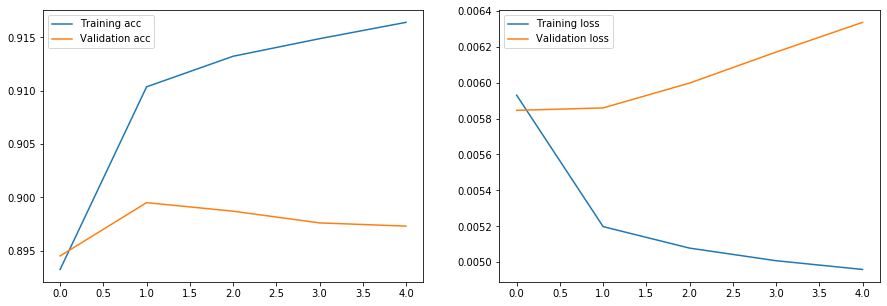

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


What we can observe in most of the cases is that training accuracy always increases (which corresponds to the network learning to classify our training data better and better), while validation accuracy may start to fall. This would indicate **overfitting**, and that is the point where we need to stop training.

## Visualizing Network Weights

It may be interesting to see if weights of a neural network make any sense. In most of the cases, when network is more complex than just one layer, it can be a difficult thing to do; however, in our case classification of a digit happpens by multiplying the initial image by a weight matrix.

Let's denote a weight tensor as `weight_tensor`, which will have a dimension of 784x10. This tensor can be obtained by calling `net.parameters()` method of our neural network. In this example, if we want to see if our number if 0 or not, we will multiply input digit by `weight_tensor[0]`, and pass the result through softmax normalization to get the answer. So we may expect that weight tensor elements might somehow resemble the average shape of the digit they classify:

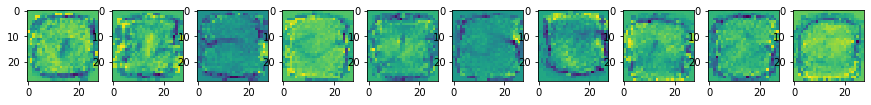

In [10]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

## Takeaway 

Training a neural netowork in PyTorch can be programmed with a training loop. It may seem like a compicated process, but in real life we need to write it once, and we can then re-use this training code later in unchanged form.

We can see that single-layer dense neural network shows relatively good performance, but we definitely want to get higher than 91% on accuracy! In the next unit, we will try to use multi-level perceptrons.